In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from prophet import Prophet
from nixtlats import TimeGPT
import xgboost as xgb
from xgboost import XGBRegressor
import os

In [144]:
def read_csv_files(folder_path):
    # Create an empty dictionary to store the DataFrames
    dfs = {}

    # Iterate over the files in the folder
    for filename in os.listdir(folder_path):
        # Check if the file is a CSV file
        if filename.endswith(".csv"):
            # Extract the product ID from the filename
            product_id = filename.split("_")[1].split(".")[0]
            product_id = int(product_id)

            # Read the DataFrame from the CSV file
            df = pd.read_csv(os.path.join(folder_path, filename))

            # Store the DataFrame in the dictionary
            dfs[product_id] = df

    # Sort the dictionary by product ID
    dfs = {key: dfs[key] for key in sorted(dfs.keys())}

    return dfs

# Datasets for test

In [145]:
test = read_csv_files('products_test')


In [146]:
for df_name, df in test.items():
    # Rename the column 'Month Year' to 'Date'
    df.rename(columns={'Month Year': 'Date'}, inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])

## Products Original

In [147]:
dfs_original_train = read_csv_files('products_original_train')

# Read CSV files from "products_original_test" folder
dfs_original_test = read_csv_files('products_original_test')

In [148]:
dfs_original_train.keys()

dict_keys([1, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 16, 20, 36])

In [149]:
dfs_original_test.keys()

dict_keys([1, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 16, 20, 36])

## Products Lag

In [150]:
dfs_lag_train = read_csv_files('products_lag_train')

# Read CSV files from "products_original_test" folder
dfs_lag_test = read_csv_files('products_lag_test')

## Product Outlier

In [151]:
dfs_outlier_train = read_csv_files('products_outliers_train')

# Read CSV files from "products_original_test" folder
dfs_outlier_test = read_csv_files('products_outliers_test')

## Test Set

In [152]:
test_set = pd.read_csv('Case2_Test Set Template.csv', sep =';')

In [153]:
test_set.head()

,Month Year,Mapped_GCK,Sales_EUR
0,Mai 22,#3,NaN
1,Jun 22,#3,NaN
2,Jul 22,#3,NaN
3,Aug 22,#3,NaN
4,Sep 22,#3,NaN


In [154]:
# month_map = {
#     'Mai': 'May', 'Okt': 'Oct', 'Dez': 'Dec'
# }

# # Aplicar o mapeamento para converter os nomes dos meses de PT para EN
# test_set['Month Year'] = test_set['Month Year'].replace(month_map, regex=True)

# # Converter 'Month Year' para o tipo datetime e formatar para 'YYYY-MM-DD'
# test_set['Month Year'] = pd.to_datetime(test_set['Month Year'] + ' 1', format='%b %y %d')

In [155]:
test_set['Mapped_GCK'] = test_set['Mapped_GCK'].str.replace('#', '')

In [156]:
print(test_set['Month Year'].isna().sum())
print(test_set['Month Year'].unique())

0
['Mai 22' 'Jun 22' 'Jul 22' 'Aug 22' 'Sep 22' 'Okt 22' 'Nov 22' 'Dez 22'
 'Jan 23' 'Feb 23']


In [157]:
test_set['Mapped_GCK'] = test_set['Mapped_GCK'].astype(int)

In [158]:
test_set.head()

,Month Year,Mapped_GCK,Sales_EUR
0,Mai 22,3,NaN
1,Jun 22,3,NaN
2,Jul 22,3,NaN
3,Aug 22,3,NaN
4,Sep 22,3,NaN


In [159]:
def date_index_to_datetime(df):
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

# Iterate over each DataFrame in the dictionary and convert the index to datetime
for dfs_dict in [dfs_original_train, dfs_original_test, dfs_lag_train, dfs_lag_test, dfs_outlier_train, dfs_outlier_test]:
    for df in dfs_dict.values():
        date_index_to_datetime(df)


In [160]:
dfs_original_train[1].dtypes

Date              datetime64[ns]
MAB_ELE_PRO276           float64
PRO27826_org             float64
MAB_ELE_PRO756           float64
MAB_ELE_PRO826           float64
PRO27840_org             float64
Sales_CPI_€              float64
dtype: object

# Remerge Datasets

In [161]:
# Initialize the remerged_data dictionary
remerged_data = {}

# Concatenate train and test sets for each product and add them to the remerged_data dictionary
remerged_data[1] = pd.concat([dfs_original_train[1].copy(), dfs_original_test[1].copy()], axis=0)
remerged_data[3] = pd.concat([dfs_outlier_train[3].copy(), dfs_outlier_test[3].copy()], axis=0)
remerged_data[4] = pd.concat([dfs_lag_train[4].copy(), dfs_lag_test[4].copy()], axis=0)
remerged_data[5] = pd.concat([dfs_lag_train[5].copy(), dfs_lag_test[5].copy()], axis=0)
remerged_data[6] = pd.concat([dfs_original_train[6].copy(), dfs_original_test[6].copy()], axis=0)
remerged_data[8] = pd.concat([dfs_lag_train[8].copy(), dfs_lag_test[8].copy()], axis=0)
remerged_data[9] = pd.concat([dfs_lag_train[9].copy(), dfs_lag_test[9].copy()], axis=0)
remerged_data[11] = pd.concat([dfs_original_train[11].copy(), dfs_original_test[11].copy()], axis=0)
remerged_data[12] = pd.concat([dfs_lag_train[12].copy(), dfs_lag_test[12].copy()], axis=0)
remerged_data[13] = pd.concat([dfs_original_train[13].copy(), dfs_original_test[13].copy()], axis=0)
remerged_data[14] = pd.concat([dfs_original_train[14].copy(), dfs_original_test[14].copy()], axis=0)
remerged_data[16] = pd.concat([dfs_original_train[16].copy(), dfs_original_test[16].copy()], axis=0)
remerged_data[20] = pd.concat([dfs_original_train[20].copy(), dfs_original_test[20].copy()], axis=0)
remerged_data[36] = pd.concat([dfs_outlier_train[36].copy(), dfs_outlier_test[36].copy()], axis=0)


# Predict Sales for each product in Test dataset

| Product ID | Model   | Dataframe | Best RMSE | Best Parameters                                    |
|------------|---------|-----------|-----------|----------------------------------------------------|
| 1          | Prophet | original  | 4436100   |                                                    |
| 3          | Prophet | outlier   | 2018385   |                                                    |
| 4          | XGBoost | lag       | 115017    | learning_rate=0.05, max_depth=3, n_estimators=1000 |
| 5          | TimeGPT | lag       | 3242273   |                                                    |
| 6          | XGBoost | original  | 207477    | learning_rate=0.01, max_depth=5, n_estimators=1000 |
| 8          | Prophet | lag       | 610963    |                                                    |
| 9          | XGBoost | lag       | 4242      | learning_rate=0.01, max_depth=5, n_estimators=100  |
| 11         | Prophet | original  | 780347    |                                                    |
| 12         | XGBoost | lag       | 106137    | learning_rate=0.01, max_depth=5, n_estimators=500  |
| 13         | XGBoost | original  | 12410     | learning_rate=0.01, max_depth=3, n_estimators=100  |
| 14         | TimeGPT | original  | 15650     |                                                    |
| 16         | TimeGPT | original  | 89173     |                                                    |
| 20         | TimeGPT | original  | 2250      |                                                    |
| 36         | XGBoost | outlier   | 15602     | learning_rate=0.05, max_depth=5, n_estimators=100  |


In [162]:
test_set

,Month Year,Mapped_GCK,Sales_EUR
0,Mai 22,3,NaN
1,Jun 22,3,NaN
2,Jul 22,3,NaN
3,Aug 22,3,NaN
4,Sep 22,3,NaN
...,...,...,...
135,Okt 22,1,NaN
136,Nov 22,1,NaN
137,Dez 22,1,NaN
138,Jan 23,1,NaN


# Predict XGBoost

In [163]:
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

def XGBoostForecast(train1, test1, product_number, learning_rate, max_depth, n_estimators):
    train_copy = train1.copy()
    test_copy = test1.copy()

    train_copy.set_index('Date', inplace=True)
    test_copy.set_index('Date', inplace=True)

    # Define X and y for training and testing
    X_train, y_train = train_copy.drop('Sales_CPI_€', axis=1), train_copy['Sales_CPI_€']
    X_test, y_test = test_copy.drop('Sales_CPI_€', axis=1), test_copy['Sales_CPI_€']
    
    # Parameters for XGBoost
    params = {
        'learning_rate': learning_rate,
        'max_depth': max_depth,
        'n_estimators': n_estimators 
    }

    # Initializing XGBRegressor
    model = XGBRegressor(**params)

    # Training the XGBoost model
    model.fit(X_train, y_train)

    # Making predictions
    forecasted_dates = test_copy.index
    predictions = model.predict(X_test)
    
    # Fill NaN values in 'Sales_EUR' column with predictions
    test_set.loc[test_set['Mapped_GCK'] == product_number, 'Sales_EUR'] = predictions
    test1['Sales_CPI_€'] = predictions

    # Plotting the forecasted values
    plt.figure(figsize=(10, 6))
    plt.plot(forecasted_dates, predictions, marker='o', linestyle='-', label='Forecasted Sales')
    plt.xlabel('Date')
    plt.ylabel('Sales (CPI €)')
    plt.title('Sales Forecast using XGBoost')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.legend()
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()

    # return predictions, forecasted_dates

# Predict Prophet

In [164]:
def ProphetForecast(train, test, product_number):
    # Initialize Prophet model
    model = Prophet()

    train_copy = train.copy()
    test_copy = test.copy()
 
    train_copy.reset_index(inplace = True)
    test_copy.reset_index(inplace = True)

    # Prepare data for Prophet
    train_prophet = train_copy.rename(columns={'Date': 'ds', 'Sales_CPI_€': 'y'})
    test_prophet = test_copy.rename(columns={'Date': 'ds', 'Sales_CPI_€': 'y'})

    # Fit the model on training data
    model.fit(train_prophet)

    # Make future dataframe for forecasting
    future = model.make_future_dataframe(periods=len(test), freq='MS')

    # Forecast
    forecast = model.predict(test_prophet)

    # Extract forecasted values for the test period
    forecast_test = forecast[-len(test):]

    test_set.loc[test_set['Mapped_GCK'] == product_number, 'Sales_EUR'] = forecast_test['yhat'].values

    # Plotting the forecasted values
    model.plot(forecast_test, xlabel='Date', ylabel='Sales (CPI €)', figsize=(10, 6))
    plt.title('Sales Forecast using Prophet')
    plt.show()

    return forecast_test['yhat'].values, forecast_test['ds'].values

# Example usage:

# Predict - TimeGPT

In [165]:
timegpt = TimeGPT(token='oQLhmPAiLjJdTk9sQBjLizwpE6w8YTOtzSVujoenJyEPH6TiJWz5ZEwJ3fk9lxhFt0sESeDkWNkdkClmhor1ikFbsa4I08qQwMEtb6lzAPCGDzuHvSA2rJWvYs8fuHkPpBSvTPMqOsUbp0ip8Okp3ZxTC4j6DByjMF2GAb2htzo1P4MRfzFtGCLsqqlI1r1EM5pC4qeZmvDNNSLCkyu7SUp8GCruLQUInMqB0MfEEsnwnHQnxJYiatoWvgdb9yie')

In [166]:
import matplotlib.pyplot as plt

def TimeGPT(df, product_number):
    df_copy = df.copy()

    df_copy.rename(columns={'Date': 'ds'}, inplace=True)

    # Make forecasts using TimeGPT
    # Note: Ensure 'timegpt.forecast' is correctly implemented and accepts 'time_col' as 'ds'
    forecasts = timegpt.forecast(df_copy, time_col="ds", h=10, freq='M', target_col='Sales_CPI_€')

    # Get forecasted values from the TimeGPT forecasts
    forecasted_values = forecasts['TimeGPT'].values

    # Extract the dates from the forecast DataFrame
    # Assuming 'forecasts' has a column named 'ds' for the dates
    forecasted_dates = forecasts['ds'].unique()
    test_set.loc[test_set['Mapped_GCK'] == product_number, 'Sales_EUR'] = forecasted_values

    # Plot the forecasted values
    plt.figure(figsize=(10, 6))
    plt.plot(forecasted_dates, forecasted_values, marker='o', linestyle='-', label='Forecasted Sales')
    plt.xlabel('Date')
    plt.ylabel('Sales (CPI €)')
    plt.title('Sales Forecast for the Next 10 Months')
    plt.legend()
    plt.show()

    return forecasted_values, forecasted_dates


### Product 4

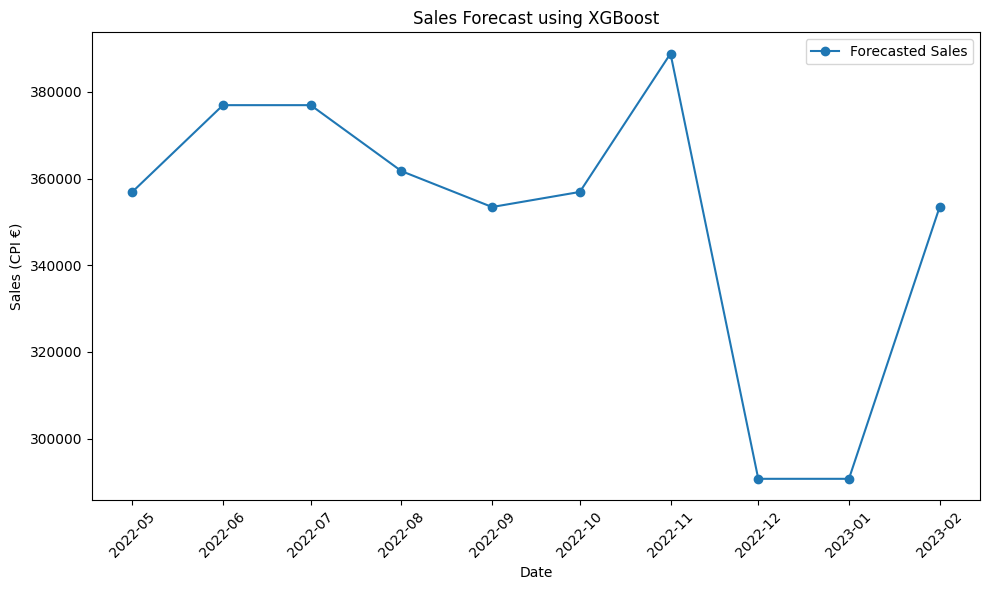

In [167]:
XGBoostForecast(remerged_data[4], test[4], 4, 0.05, 3, 1000)

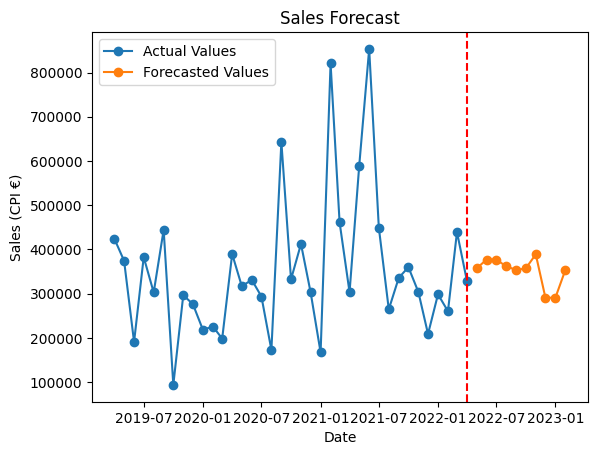

In [168]:
# Plot the actual values
plt.plot(remerged_data[4]['Date'], remerged_data[4]['Sales_CPI_€'], marker='o', linestyle='-', label='Actual Values')

# Plot the forecasted values
plt.plot(test[4]['Date'], test[4]['Sales_CPI_€'], marker='o', linestyle='-', label='Forecasted Values')

# Add a vertical line to separate the actual and forecasted values
plt.axvline(x=remerged_data[4]['Date'].iloc[-1], color='r', linestyle='--')

# Set the x-axis label
plt.xlabel('Date')

# Set the y-axis label
plt.ylabel('Sales (CPI €)')

# Set the title of the graph
plt.title('Sales Forecast')

# Add a legend
plt.legend()

# Display the graph
plt.show()


### Product 6

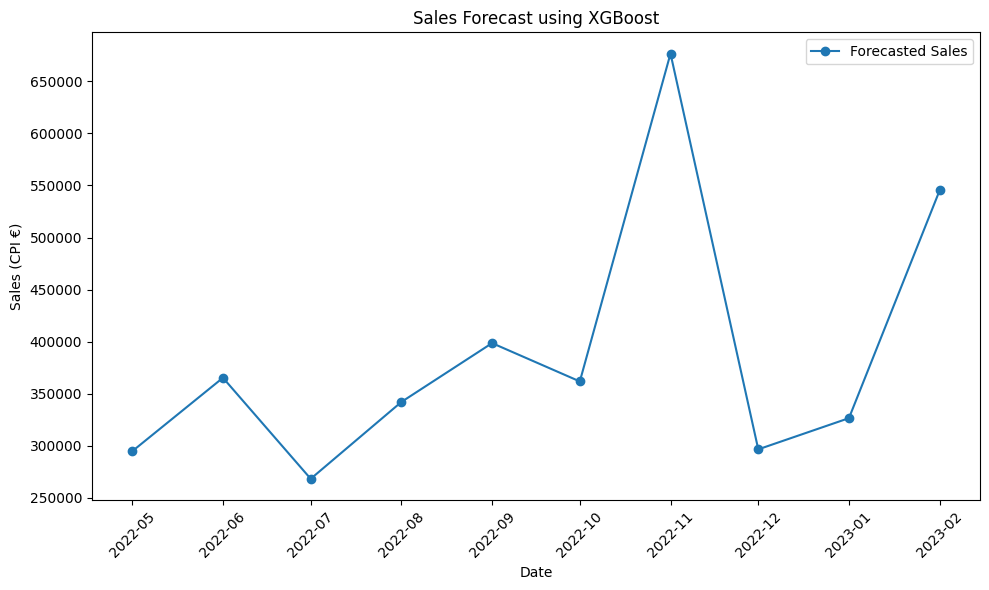

In [169]:
XGBoostForecast(remerged_data[6], test[6], 6, 0.01, 5, 1000)

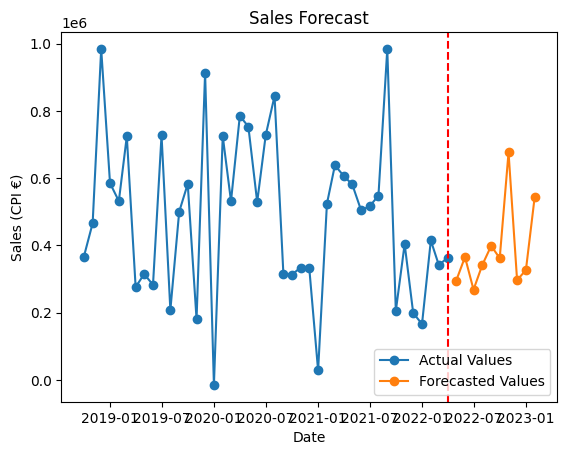

In [170]:
# Plot the actual values
plt.plot(remerged_data[6]['Date'], remerged_data[6]['Sales_CPI_€'], marker='o', linestyle='-', label='Actual Values')

# Plot the forecasted values
plt.plot(test[6]['Date'], test[6]['Sales_CPI_€'], marker='o', linestyle='-', label='Forecasted Values')

# Add a vertical line to separate the actual and forecasted values
plt.axvline(x=remerged_data[6]['Date'].iloc[-1], color='r', linestyle='--')

# Set the x-axis label
plt.xlabel('Date')

# Set the y-axis label
plt.ylabel('Sales (CPI €)')

# Set the title of the graph
plt.title('Sales Forecast')

# Add a legend
plt.legend()

# Display the graph
plt.show()


### Product 9

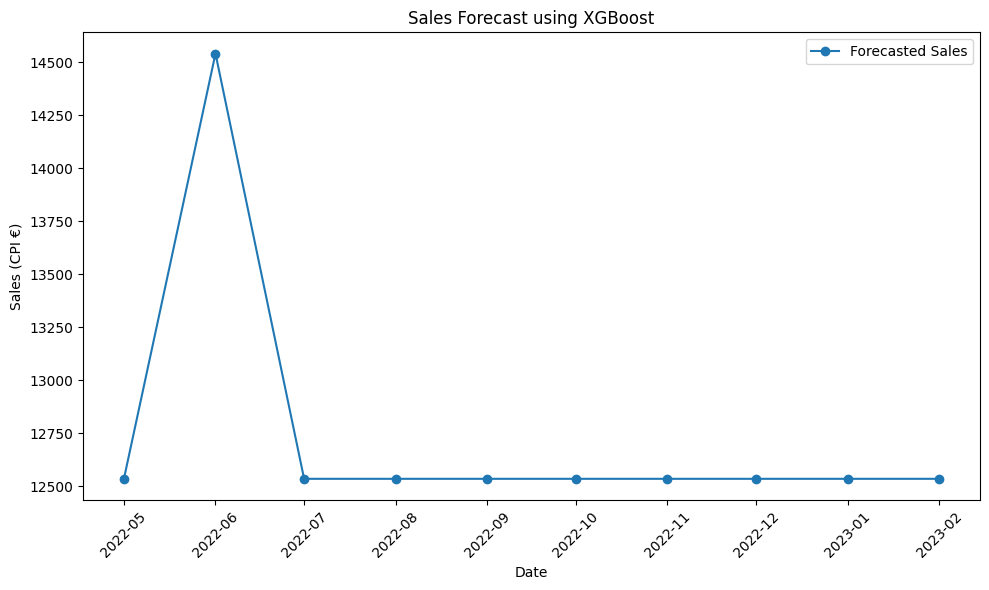

In [171]:
XGBoostForecast(remerged_data[9], test[9], 9, 0.01, 5, 100)

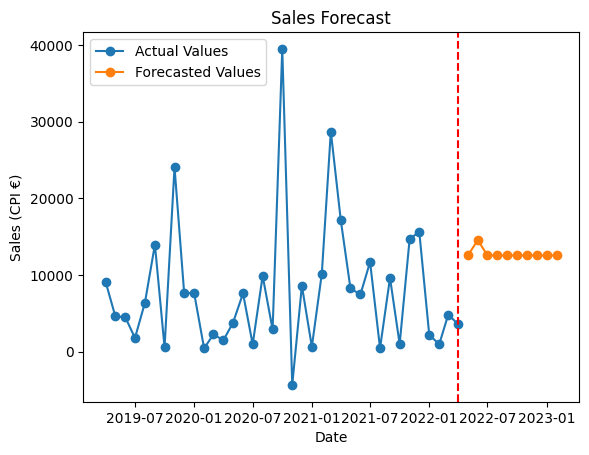

In [172]:
# Plot the actual values
plt.plot(remerged_data[9]['Date'], remerged_data[9]['Sales_CPI_€'], marker='o', linestyle='-', label='Actual Values')

# Plot the forecasted values
plt.plot(test[9]['Date'], test[9]['Sales_CPI_€'], marker='o', linestyle='-', label='Forecasted Values')

# Add a vertical line to separate the actual and forecasted values
plt.axvline(x=remerged_data[9]['Date'].iloc[-1], color='r', linestyle='--')

# Set the x-axis label
plt.xlabel('Date')

# Set the y-axis label
plt.ylabel('Sales (CPI €)')

# Set the title of the graph
plt.title('Sales Forecast')

# Add a legend
plt.legend()

# Display the graph
plt.show()


### Product 12

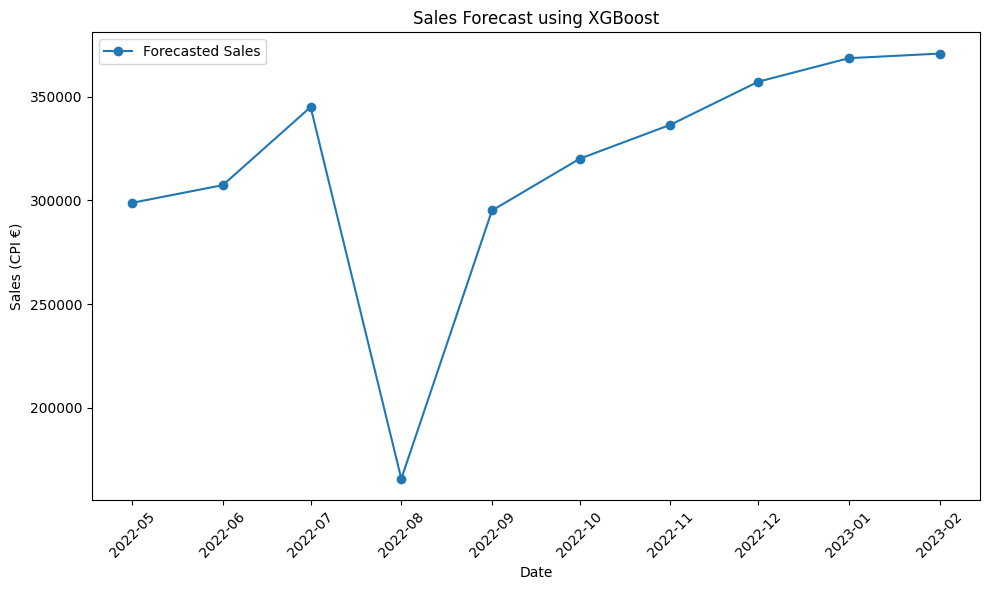

In [173]:
XGBoostForecast(remerged_data[12], test[12], 12, 0.01, 5, 500)

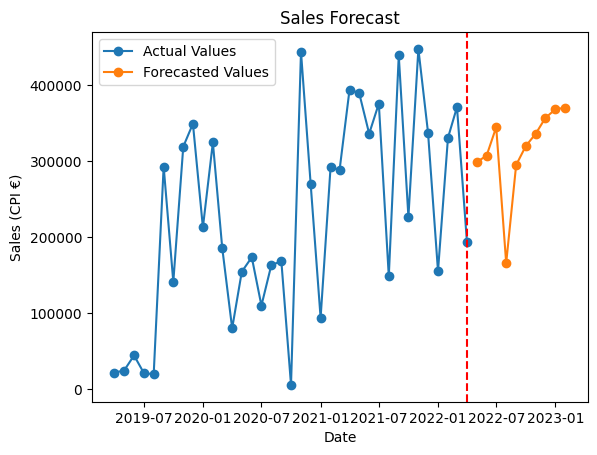

In [174]:
# Plot the actual values
plt.plot(remerged_data[12]['Date'], remerged_data[12]['Sales_CPI_€'], marker='o', linestyle='-', label='Actual Values')

# Plot the forecasted values
plt.plot(test[12]['Date'], test[12]['Sales_CPI_€'], marker='o', linestyle='-', label='Forecasted Values')

# Add a vertical line to separate the actual and forecasted values
plt.axvline(x=remerged_data[12]['Date'].iloc[-1], color='r', linestyle='--')

# Set the x-axis label
plt.xlabel('Date')

# Set the y-axis label
plt.ylabel('Sales (CPI €)')

# Set the title of the graph
plt.title('Sales Forecast')

# Add a legend
plt.legend()

# Display the graph
plt.show()


### Product 13

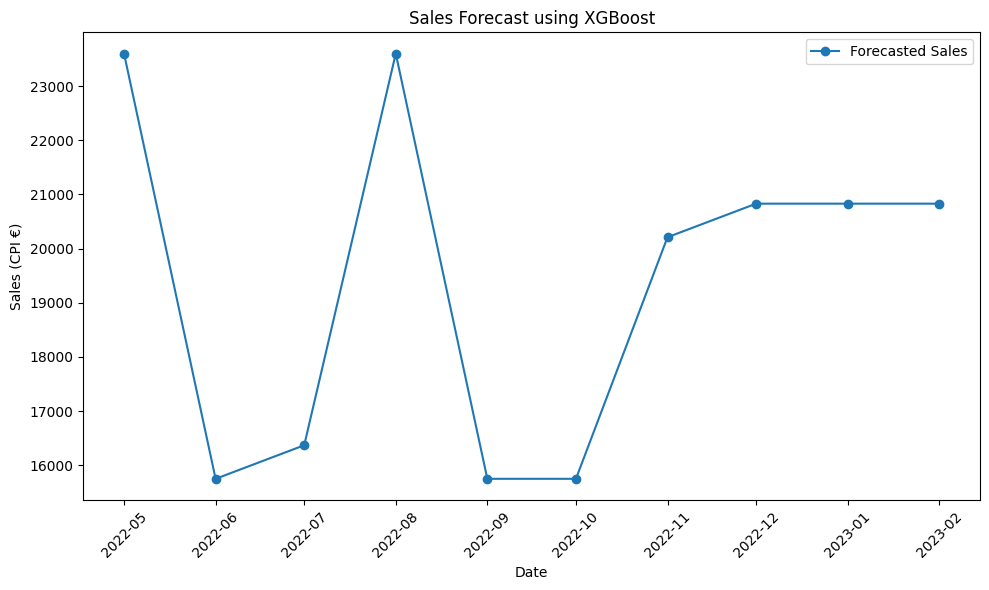

In [175]:
XGBoostForecast(remerged_data[13], test[13], 13, 0.01, 3, 100)

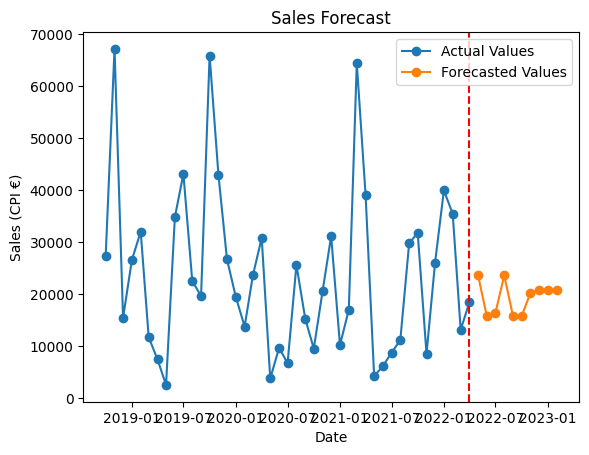

In [176]:
# Plot the actual values
plt.plot(remerged_data[13]['Date'], remerged_data[13]['Sales_CPI_€'], marker='o', linestyle='-', label='Actual Values')

# Plot the forecasted values
plt.plot(test[13]['Date'], test[13]['Sales_CPI_€'], marker='o', linestyle='-', label='Forecasted Values')

# Add a vertical line to separate the actual and forecasted values
plt.axvline(x=remerged_data[13]['Date'].iloc[-1], color='r', linestyle='--')

# Set the x-axis label
plt.xlabel('Date')

# Set the y-axis label
plt.ylabel('Sales (CPI €)')

# Set the title of the graph
plt.title('Sales Forecast')

# Add a legend
plt.legend()

# Display the graph
plt.show()


### Product 36

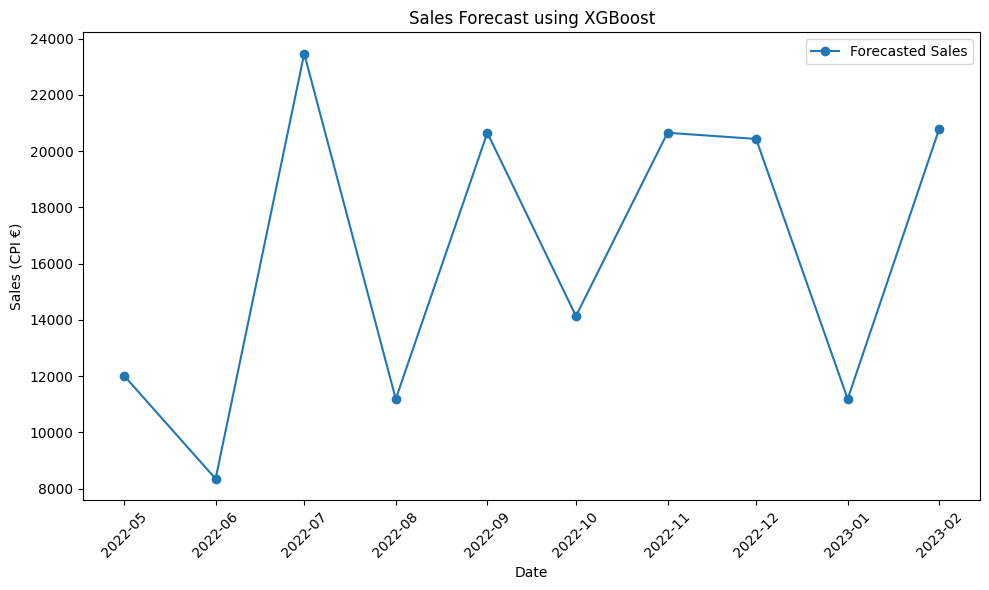

In [177]:
XGBoostForecast(remerged_data[36], test[36], 36, 0.05, 5, 100)

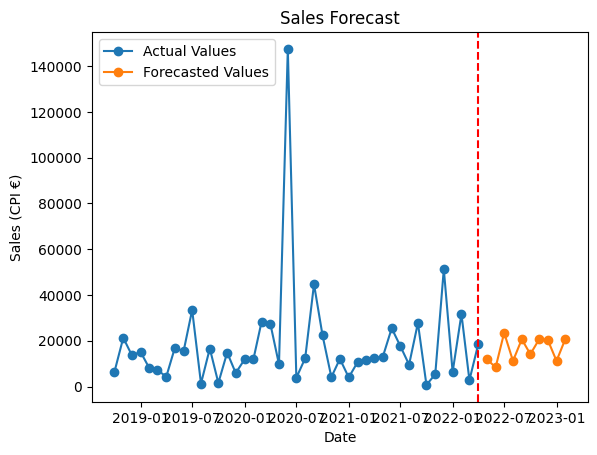

In [178]:
# Plot the actual values
plt.plot(remerged_data[36]['Date'], remerged_data[36]['Sales_CPI_€'], marker='o', linestyle='-', label='Actual Values')

# Plot the forecasted values
plt.plot(test[36]['Date'], test[36]['Sales_CPI_€'], marker='o', linestyle='-', label='Forecasted Values')

# Add a vertical line to separate the actual and forecasted values
plt.axvline(x=remerged_data[36]['Date'].iloc[-1], color='r', linestyle='--')

# Set the x-axis label
plt.xlabel('Date')

# Set the y-axis label
plt.ylabel('Sales (CPI €)')

# Set the title of the graph
plt.title('Sales Forecast')

# Add a legend
plt.legend()

# Display the graph
plt.show()


## Product 5

INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Inferred freq: MS
INFO:nixtlats.timegpt:Calling Forecast Endpoint...
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


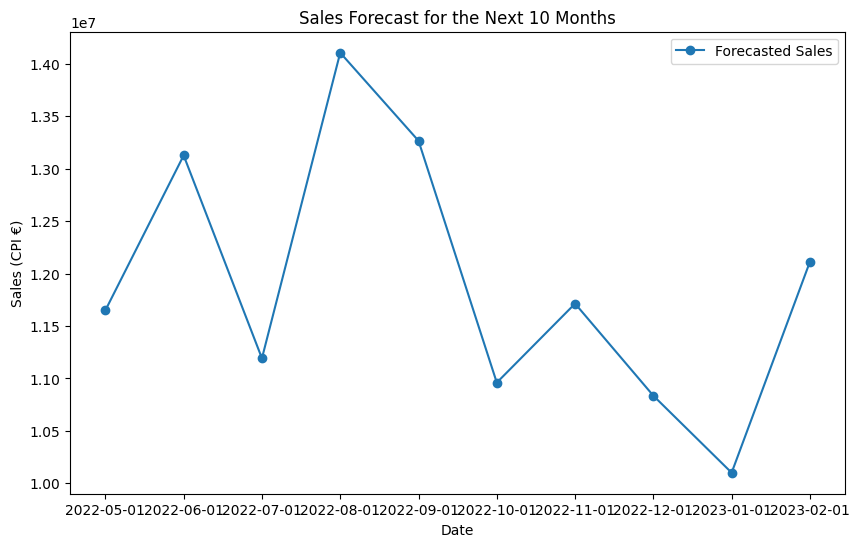

In [179]:
forecasted_values, forecasted_dates = TimeGPT(remerged_data[5], 5)

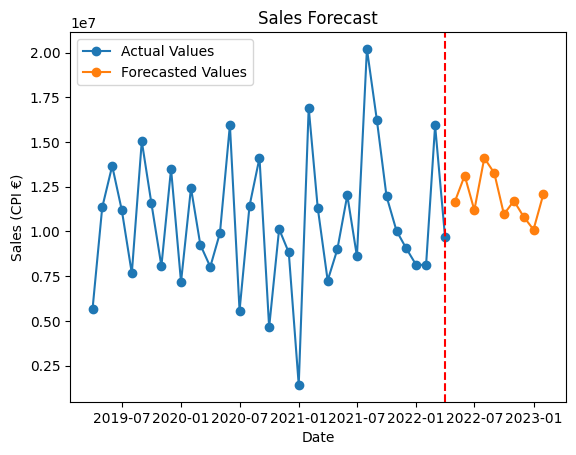

In [180]:
# set 'date' to datetime
forecasted_dates = pd.to_datetime(forecasted_dates)

# actual dates are 'date' in remerged_data[1]
actual_dates = remerged_data[5]['Date'].values
# actual values are the 'sales_cpi_€' corresponding to the actual dates
actual_values = remerged_data[5]['Sales_CPI_€'].values

# Plot the actual values
plt.plot(actual_dates, actual_values, marker='o', linestyle='-', label='Actual Values')

# Plot the forecasted values
plt.plot(forecasted_dates, forecasted_values, marker='o', linestyle='-', label='Forecasted Values')

# Add a vertical line to separate the actual and forecasted values
plt.axvline(x=actual_dates[-1], color='r', linestyle='--')

# Set the x-axis label
plt.xlabel('Date')

# Set the y-axis label
plt.ylabel('Sales (CPI €)')

# Set the title of the graph
plt.title('Sales Forecast')

# Add a legend
plt.legend()

# Display the graph
plt.show()


## Product 14

INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Inferred freq: MS
INFO:nixtlats.timegpt:Calling Forecast Endpoint...
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


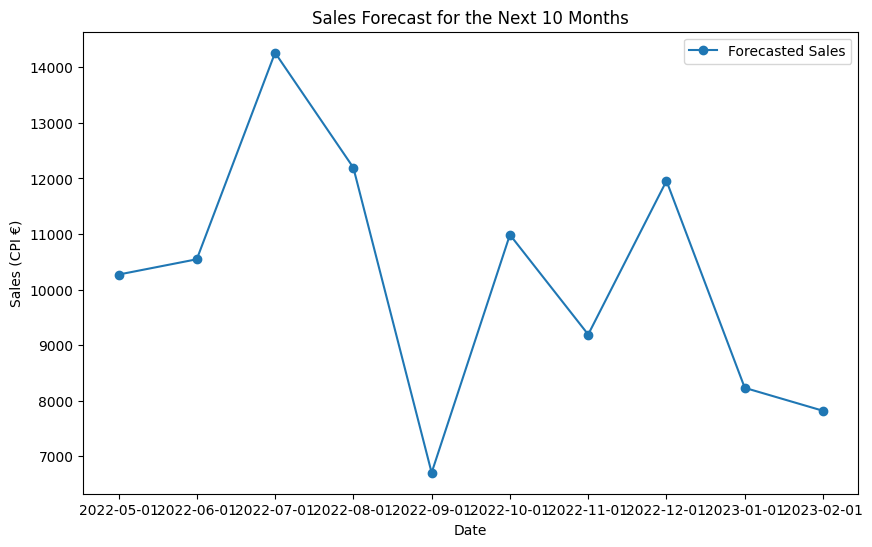

In [181]:
forecasted_values, forecasted_dates = TimeGPT(remerged_data[14], 14)

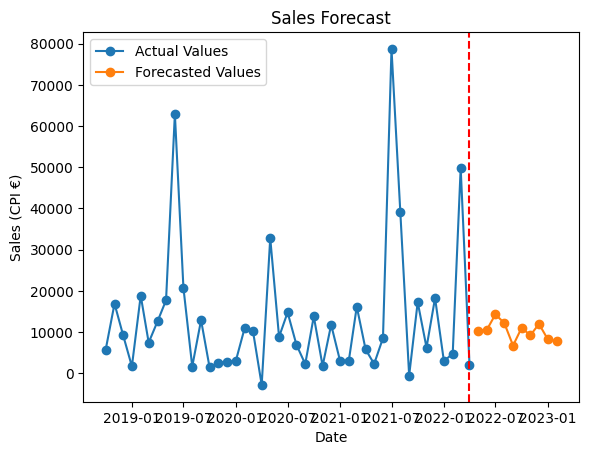

In [182]:
# set 'date' to datetime
forecasted_dates = pd.to_datetime(forecasted_dates)

# actual dates are 'date' in remerged_data[1]
actual_dates = remerged_data[14]['Date'].values
# actual values are the 'sales_cpi_€' corresponding to the actual dates
actual_values = remerged_data[14]['Sales_CPI_€'].values

# Plot the actual values
plt.plot(actual_dates, actual_values, marker='o', linestyle='-', label='Actual Values')

# Plot the forecasted values
plt.plot(forecasted_dates, forecasted_values, marker='o', linestyle='-', label='Forecasted Values')

# Add a vertical line to separate the actual and forecasted values
plt.axvline(x=actual_dates[-1], color='r', linestyle='--')

# Set the x-axis label
plt.xlabel('Date')

# Set the y-axis label
plt.ylabel('Sales (CPI €)')

# Set the title of the graph
plt.title('Sales Forecast')

# Add a legend
plt.legend()

# Display the graph
plt.show()


## Product 16

INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Inferred freq: MS
INFO:nixtlats.timegpt:Calling Forecast Endpoint...
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


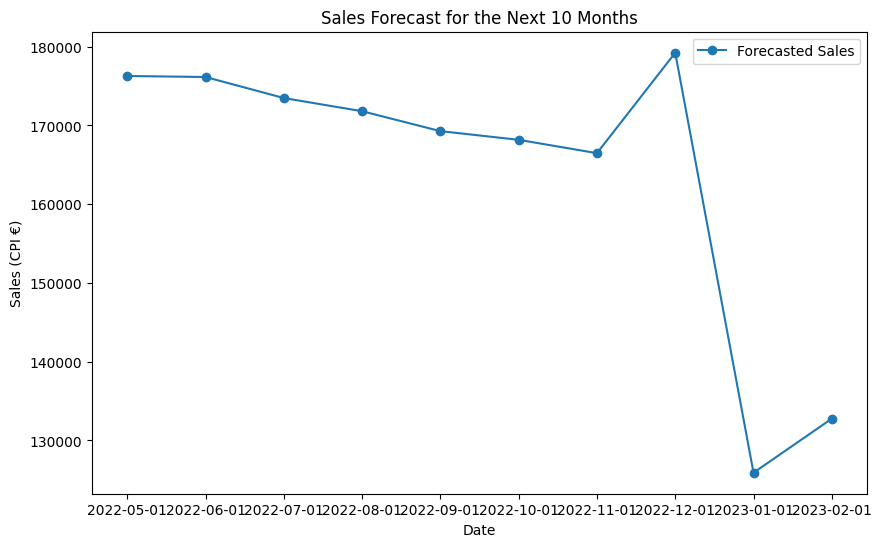

In [183]:
forecasted_values, forecasted_dates = TimeGPT(remerged_data[16], 16)

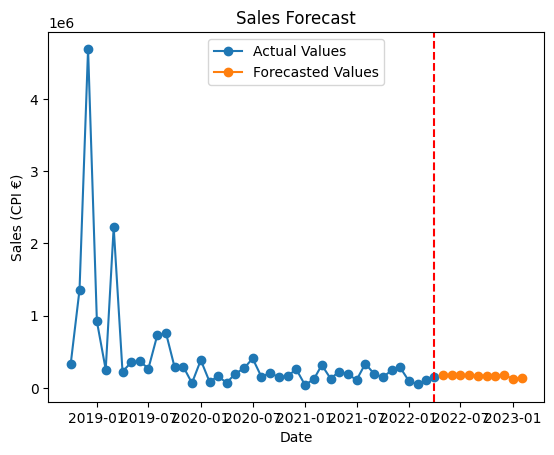

In [184]:
# set 'date' to datetime
forecasted_dates = pd.to_datetime(forecasted_dates)

# actual dates are 'date' in remerged_data[1]
actual_dates = remerged_data[16]['Date'].values
# actual values are the 'sales_cpi_€' corresponding to the actual dates
actual_values = remerged_data[16]['Sales_CPI_€'].values

# Plot the actual values
plt.plot(actual_dates, actual_values, marker='o', linestyle='-', label='Actual Values')

# Plot the forecasted values
plt.plot(forecasted_dates, forecasted_values, marker='o', linestyle='-', label='Forecasted Values')

# Add a vertical line to separate the actual and forecasted values
plt.axvline(x=actual_dates[-1], color='r', linestyle='--')

# Set the x-axis label
plt.xlabel('Date')

# Set the y-axis label
plt.ylabel('Sales (CPI €)')

# Set the title of the graph
plt.title('Sales Forecast')

# Add a legend
plt.legend()

# Display the graph
plt.show()


## Product 20

INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Inferred freq: MS
INFO:nixtlats.timegpt:Calling Forecast Endpoint...
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


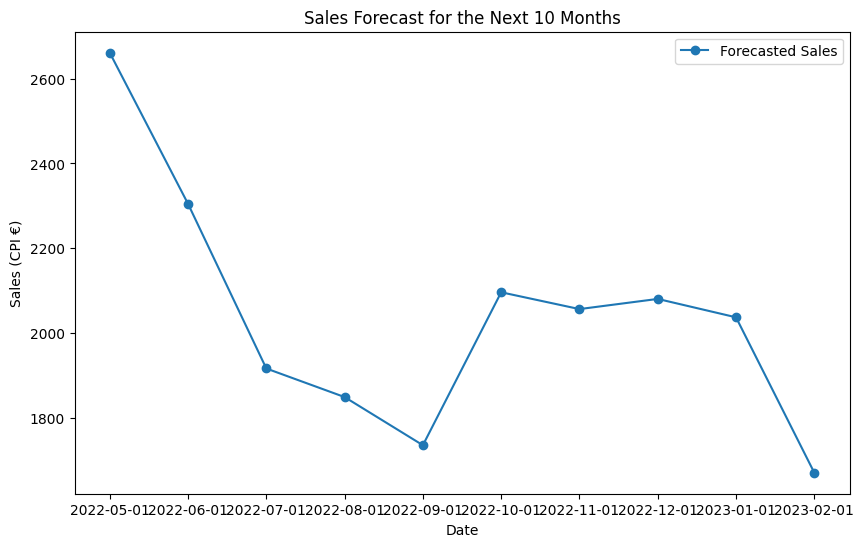

In [185]:
forecasted_values, forecasted_dates = TimeGPT(remerged_data[20], 20)

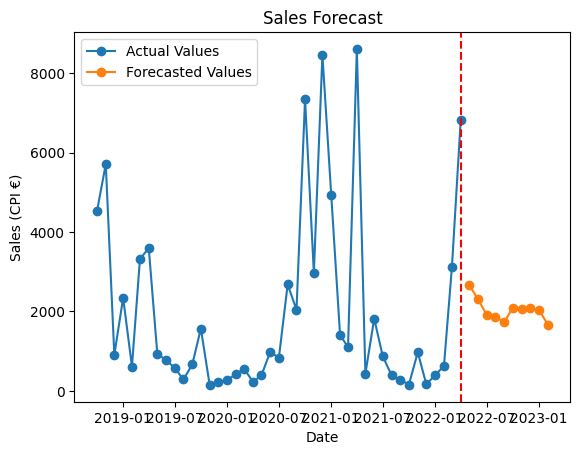

In [186]:
# set 'date' to datetime
forecasted_dates = pd.to_datetime(forecasted_dates)

# actual dates are 'date' in remerged_data[1]
actual_dates = remerged_data[20]['Date'].values
# actual values are the 'sales_cpi_€' corresponding to the actual dates
actual_values = remerged_data[20]['Sales_CPI_€'].values

# Plot the actual values
plt.plot(actual_dates, actual_values, marker='o', linestyle='-', label='Actual Values')

# Plot the forecasted values
plt.plot(forecasted_dates, forecasted_values, marker='o', linestyle='-', label='Forecasted Values')

# Add a vertical line to separate the actual and forecasted values
plt.axvline(x=actual_dates[-1], color='r', linestyle='--')

# Set the x-axis label
plt.xlabel('Date')

# Set the y-axis label
plt.ylabel('Sales (CPI €)')

# Set the title of the graph
plt.title('Sales Forecast')

# Add a legend
plt.legend()

# Display the graph
plt.show()


## Predict Prophet

### Product 1

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\User\AppData\Local\Temp\tmpmcaoy_c5\e2e7ff3k.json
DEBUG:cmdstanpy:input tempfile: C:\Users\User\AppData\Local\Temp\tmpmcaoy_c5\8xbhwiyf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\User\\anaconda3\\envs\\DM2324\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=25273', 'data', 'file=C:\\Users\\User\\AppData\\Local\\Temp\\tmpmcaoy_c5\\e2e7ff3k.json', 'init=C:\\Users\\User\\AppData\\Local\\Temp\\tmpmcaoy_c5\\8xbhwiyf.json', 'output', 'file=C:\\Users\\User\\AppData\\Local\\Temp\\tmpmcaoy_c5\\prophet_modelugfe9_92\\prophet_model-20240410155604.csv', 'metho

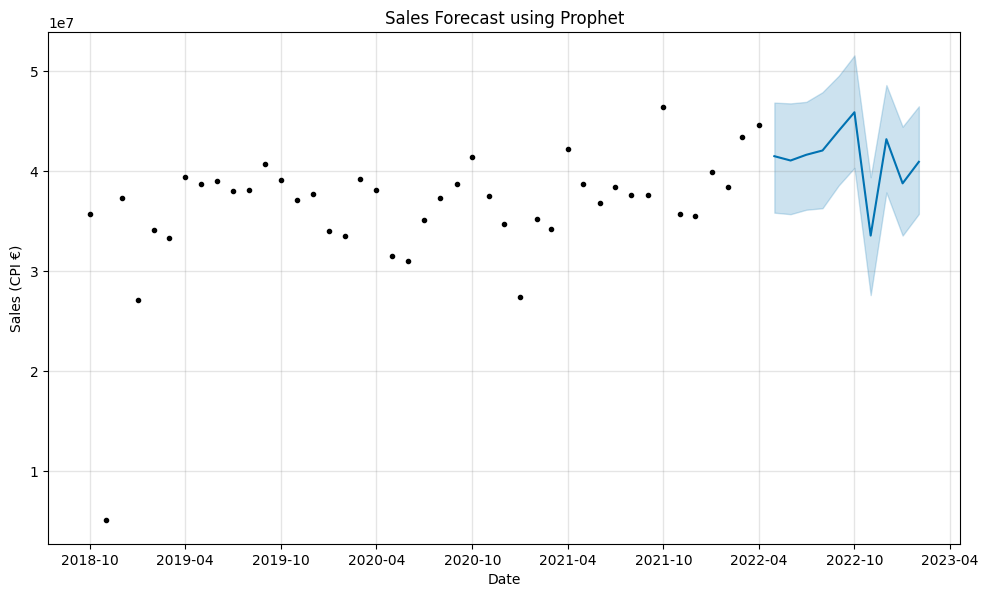

In [187]:
prophet_predictions, prophet_forecasted_dates = ProphetForecast(remerged_data[1], test[1], 1)

### Product 3

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\User\AppData\Local\Temp\tmpmcaoy_c5\83ctqbsb.json
DEBUG:cmdstanpy:input tempfile: C:\Users\User\AppData\Local\Temp\tmpmcaoy_c5\t3ibpqlj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\User\\anaconda3\\envs\\DM2324\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=37147', 'data', 'file=C:\\Users\\User\\AppData\\Local\\Temp\\tmpmcaoy_c5\\83ctqbsb.json', 'init=C:\\Users\\User\\AppData\\Local\\Temp\\tmpmcaoy_c5\\t3ibpqlj.json', 'output', 'file=C:\\Users\\User\\AppData\\Local\\Temp\\tmpmcaoy_c5\\prophet_modelfyziu9dy\\prophet_model-20240410155605.csv', 'metho

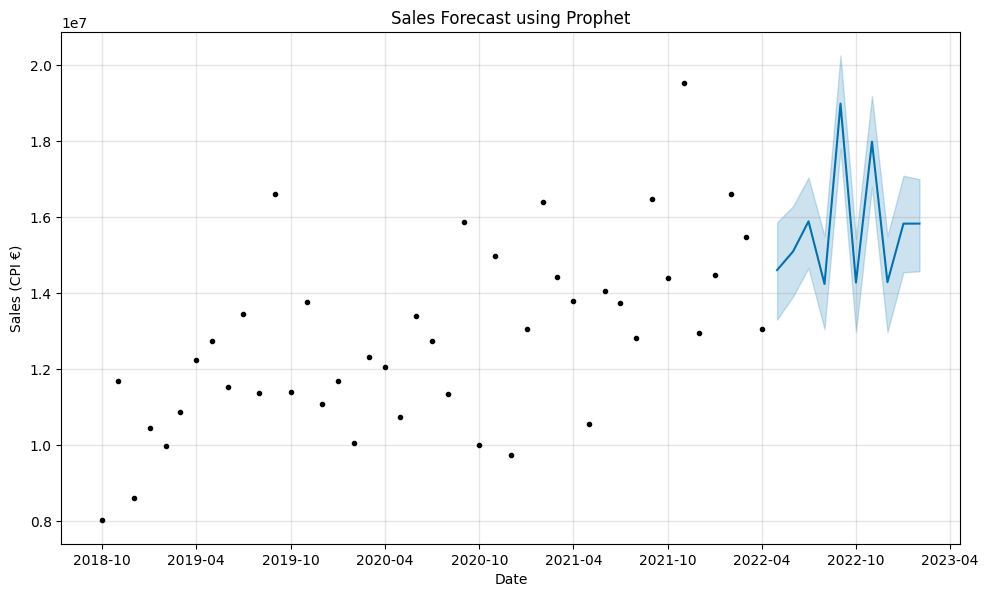

In [188]:
prophet_predictions, prophet_forecasted_dates = ProphetForecast(remerged_data[3], test[3], 3)

### Product 8

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\User\AppData\Local\Temp\tmpmcaoy_c5\2vsifx87.json
DEBUG:cmdstanpy:input tempfile: C:\Users\User\AppData\Local\Temp\tmpmcaoy_c5\_4oyhyp0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\User\\anaconda3\\envs\\DM2324\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=19017', 'data', 'file=C:\\Users\\User\\AppData\\Local\\Temp\\tmpmcaoy_c5\\2vsifx87.json', 'init=C:\\Users\\User\\AppData\\Local\\Temp\\tmpmcaoy_c5\\_4oyhyp0.json', 'output', 'file=C:\\Users\\User\\AppData\\Local\\Temp\\tmpmcaoy_c5\\prophet_modelhyzpus20\\prophet_model-20240410155606.csv', 'metho

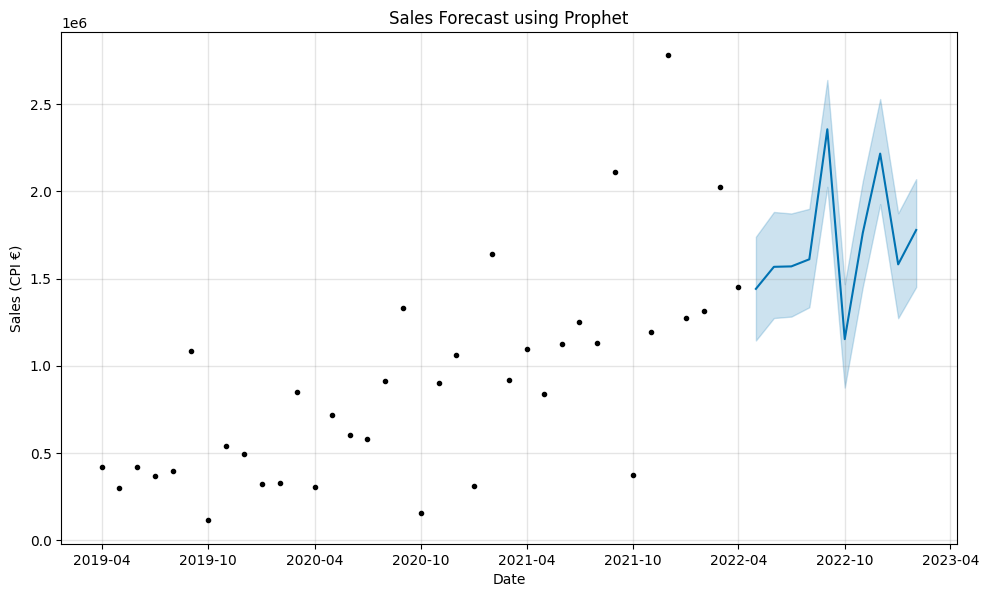

In [189]:
prophet_predictions, prophet_forecasted_dates = ProphetForecast(remerged_data[8], test[8], 8)

### Product 11

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\User\AppData\Local\Temp\tmpmcaoy_c5\_fasn3zo.json
DEBUG:cmdstanpy:input tempfile: C:\Users\User\AppData\Local\Temp\tmpmcaoy_c5\4wm35uf3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\User\\anaconda3\\envs\\DM2324\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=38038', 'data', 'file=C:\\Users\\User\\AppData\\Local\\Temp\\tmpmcaoy_c5\\_fasn3zo.json', 'init=C:\\Users\\User\\AppData\\Local\\Temp\\tmpmcaoy_c5\\4wm35uf3.json', 'output', 'file=C:\\Users\\User\\AppData\\Local\\Temp\\tmpmcaoy_c5\\prophet_modelloryju4u\\prophet_model-20240410155607.csv', 'metho

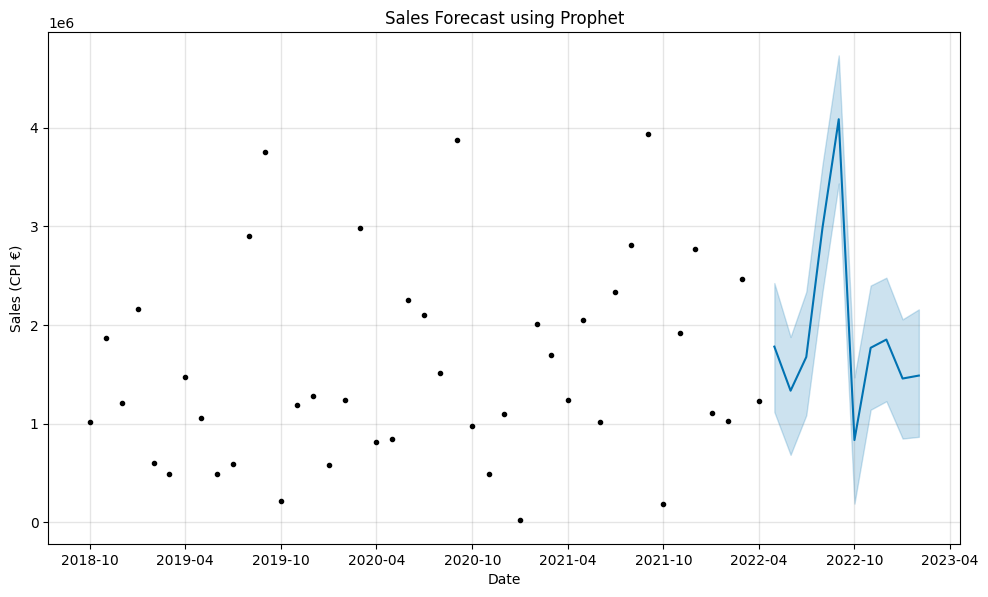

In [190]:
prophet_predictions, prophet_forecasted_dates = ProphetForecast(remerged_data[11], test[11], 11)

# Export test_set

In [191]:
test_set['Mapped_GCK'] = test_set['Mapped_GCK'].apply(lambda x: '#' + str(x))

In [192]:
test_set

,Month Year,Mapped_GCK,Sales_EUR
0,Mai 22,#3,1.460727e+07
1,Jun 22,#3,1.509702e+07
2,Jul 22,#3,1.589101e+07
3,Aug 22,#3,1.424237e+07
4,Sep 22,#3,1.898924e+07
...,...,...,...
135,Okt 22,#1,4.590601e+07
136,Nov 22,#1,3.356648e+07
137,Dez 22,#1,4.321086e+07
138,Jan 23,#1,3.879174e+07


In [256]:
sales_predict = test_set.copy()

In [257]:
month_map = {
     'Mai': 'May', 'Okt': 'Oct', 'Dez': 'Dec'
 }

 # Aplicar o mapeamento para converter os nomes dos meses de PT para EN
sales_predict['Month Year'] = sales_predict['Month Year'].replace(month_map, regex=True)

 # Converter 'Month Year' para o tipo datetime e formatar para 'YYYY-MM-DD'
sales_predict['Month Year'] = pd.to_datetime(sales_predict['Month Year'] + ' 1', format='%b %y %d')

# Replace characters in the index
sales_predict['Mapped_GCK'] = sales_predict['Mapped_GCK'].str.replace('#', '')


In [258]:
# Convert 'Mapped_GCK' column to numeric
sales_predict['Mapped_GCK'] = pd.to_numeric(sales_predict['Mapped_GCK'])

# Sort the DataFrame by 'Mapped_GCK' column
sales_predict = sales_predict.sort_values(by='Mapped_GCK', ascending=True)

# Reset the index
sales_predict = sales_predict.reset_index(drop=True)


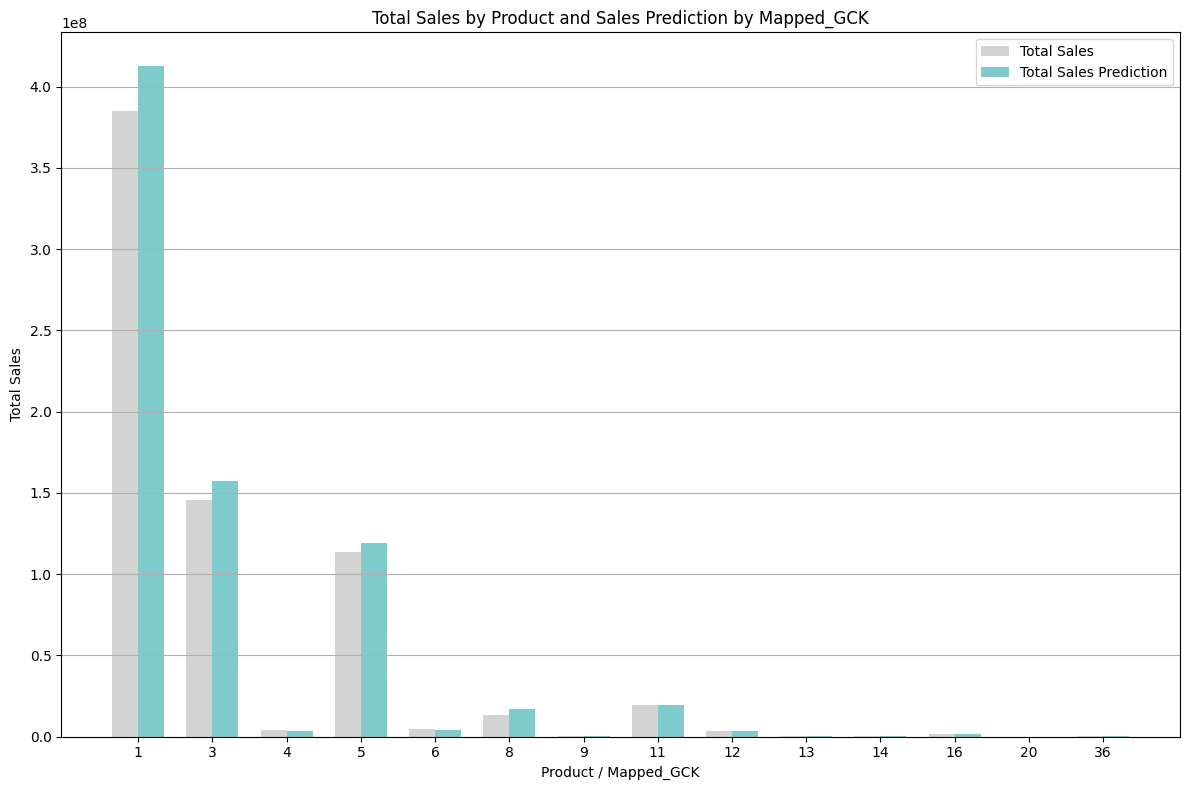

In [275]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming remerged_data is your DataFrame and specific_products is defined

specific_dates = ['2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01', '2022-01-01', '2022-02-01']
specific_dates_datetime = pd.to_datetime(specific_dates)

# Initialize an empty dictionary to store filtered DataFrames
filtered_remerged_data = {}

# Iterate through each key (product) in remerged_data
for key, df in remerged_data.items():
    # Convert the 'Date' column to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    # Filter the DataFrame for the desired dates
    filtered_remerged_data[key] = df[df['Date'].isin(specific_dates_datetime)]

# Calculate the total sales for the filtered remerged_data DataFrame
summed_filtered_sales = {}

for product_key, df in filtered_remerged_data.items():
    summed_filtered_sales[product_key] = df['Sales_CPI_€'].sum()

# Convert the dictionary of summed filtered sales to a DataFrame
summed_filtered_sales_df = pd.DataFrame.from_dict(summed_filtered_sales, orient='index', columns=['Total Sales'])

# Group by Mapped_GCK and sum the Sales_EUR
sum_sales_predict = sales_predict.groupby('Mapped_GCK')['Sales_EUR'].sum()

# Reorder the sum_sales_predict to match the order of products in summed_filtered_sales_df
sum_sales_predict_ordered = sum_sales_predict.reindex(summed_filtered_sales_df.index)

## Plotting
plt.figure(figsize=(12, 8))

# Define the width of each bar
bar_width = 0.35

# Define the index for the x-axis for the first bar plot (filtered remerged_data)
index_filtered = range(len(summed_filtered_sales_df))

# Plot the bar plot for total sales by product (filtered remerged_data)
plt.bar(index_filtered, summed_filtered_sales_df['Total Sales'], bar_width, color='lightgray', label='Total Sales')

# Define the index for the x-axis for the second bar plot (sales prediction)
index_predict = [i + bar_width for i in index_filtered]

# Plot the bar plot for total sales prediction by Mapped_GCK
plt.bar(index_predict, sum_sales_predict_ordered, bar_width, color="#009999", alpha=0.5, label='Total Sales Prediction')

# Set the x-axis ticks
plt.xticks([i + bar_width / 2 for i in index_filtered], summed_filtered_sales_df.index)

plt.title('Total Sales by Product and Sales Prediction by Mapped_GCK')
plt.xlabel('Product / Mapped_GCK')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


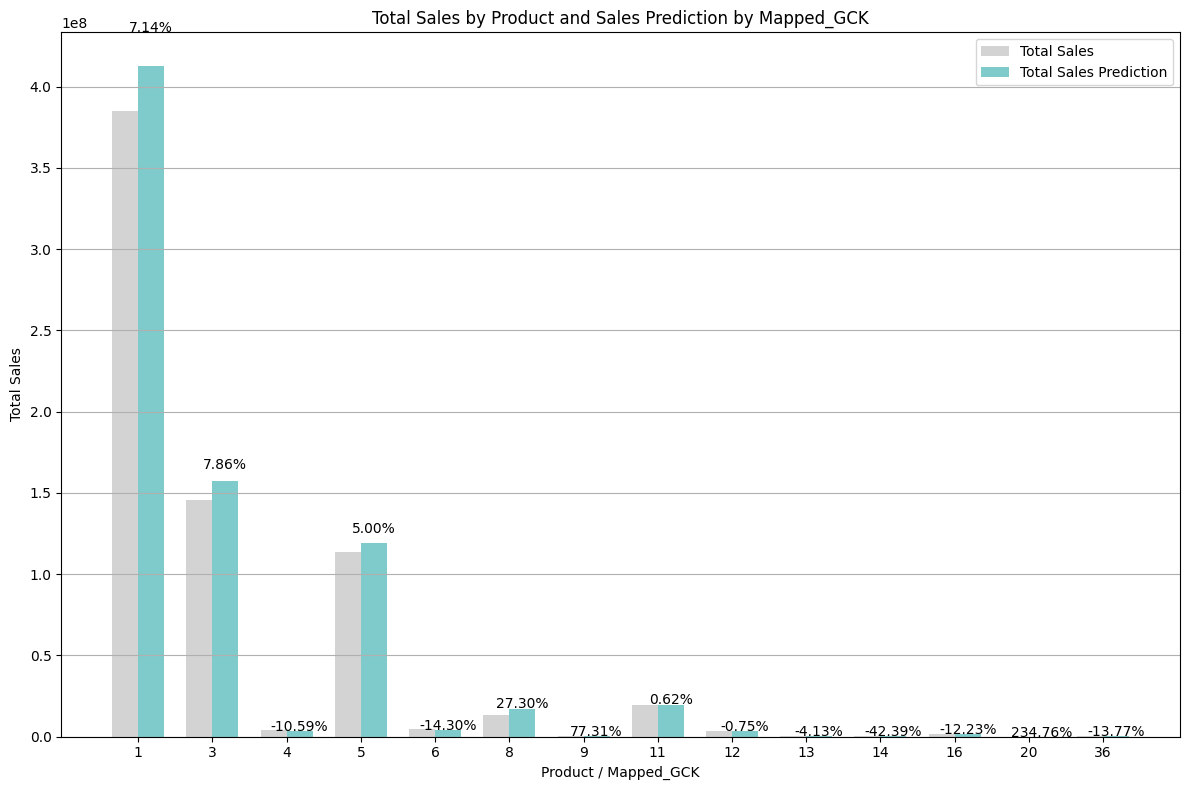

In [274]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming remerged_data is your DataFrame and specific_products is defined

specific_dates = ['2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01', '2022-01-01', '2022-02-01']
specific_dates_datetime = pd.to_datetime(specific_dates)

# Initialize an empty dictionary to store filtered DataFrames
filtered_remerged_data = {}

# Iterate through each key (product) in remerged_data
for key, df in remerged_data.items():
    # Convert the 'Date' column to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    # Filter the DataFrame for the desired dates
    filtered_remerged_data[key] = df[df['Date'].isin(specific_dates_datetime)]

# Calculate the total sales for the filtered remerged_data DataFrame
summed_filtered_sales = {}

for product_key, df in filtered_remerged_data.items():
    summed_filtered_sales[product_key] = df['Sales_CPI_€'].sum()

# Convert the dictionary of summed filtered sales to a DataFrame
summed_filtered_sales_df = pd.DataFrame.from_dict(summed_filtered_sales, orient='index', columns=['Total Sales'])

# Group by Mapped_GCK and sum the Sales_EUR
sum_sales_predict = sales_predict.groupby('Mapped_GCK')['Sales_EUR'].sum()

# Reorder the sum_sales_predict to match the order of products in summed_filtered_sales_df
sum_sales_predict_ordered = sum_sales_predict.reindex(summed_filtered_sales_df.index)

# Calculate the difference percentage
difference_percentage = ((sum_sales_predict_ordered - summed_filtered_sales_df['Total Sales']) / summed_filtered_sales_df['Total Sales']) * 100

## Plotting
plt.figure(figsize=(12, 8))

# Define the width of each bar
bar_width = 0.35

# Define the index for the x-axis for the first bar plot (filtered remerged_data)
index_filtered = range(len(summed_filtered_sales_df))

# Plot the bar plot for total sales by product (filtered remerged_data)
plt.bar(index_filtered, summed_filtered_sales_df['Total Sales'], bar_width, color='lightgray', label='Total Sales')

# Define the index for the x-axis for the second bar plot (sales prediction)
index_predict = [i + bar_width for i in index_filtered]

# Plot the bar plot for total sales prediction by Mapped_GCK
plt.bar(index_predict, sum_sales_predict_ordered, bar_width, color="#009999", alpha=0.5, label='Total Sales Prediction')

# Display the difference percentage as text on the graph
for i, (x, y) in enumerate(zip(index_predict, sum_sales_predict_ordered)):
    plt.text(x, y + 0.05 * y, f'{difference_percentage.iloc[i]:.2f}%', ha='center')

# Set the x-axis ticks
plt.xticks([i + bar_width / 2 for i in index_filtered], summed_filtered_sales_df.index)

plt.title('Total Sales by Product and Sales Prediction by Mapped_GCK')
plt.xlabel('Product / Mapped_GCK')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


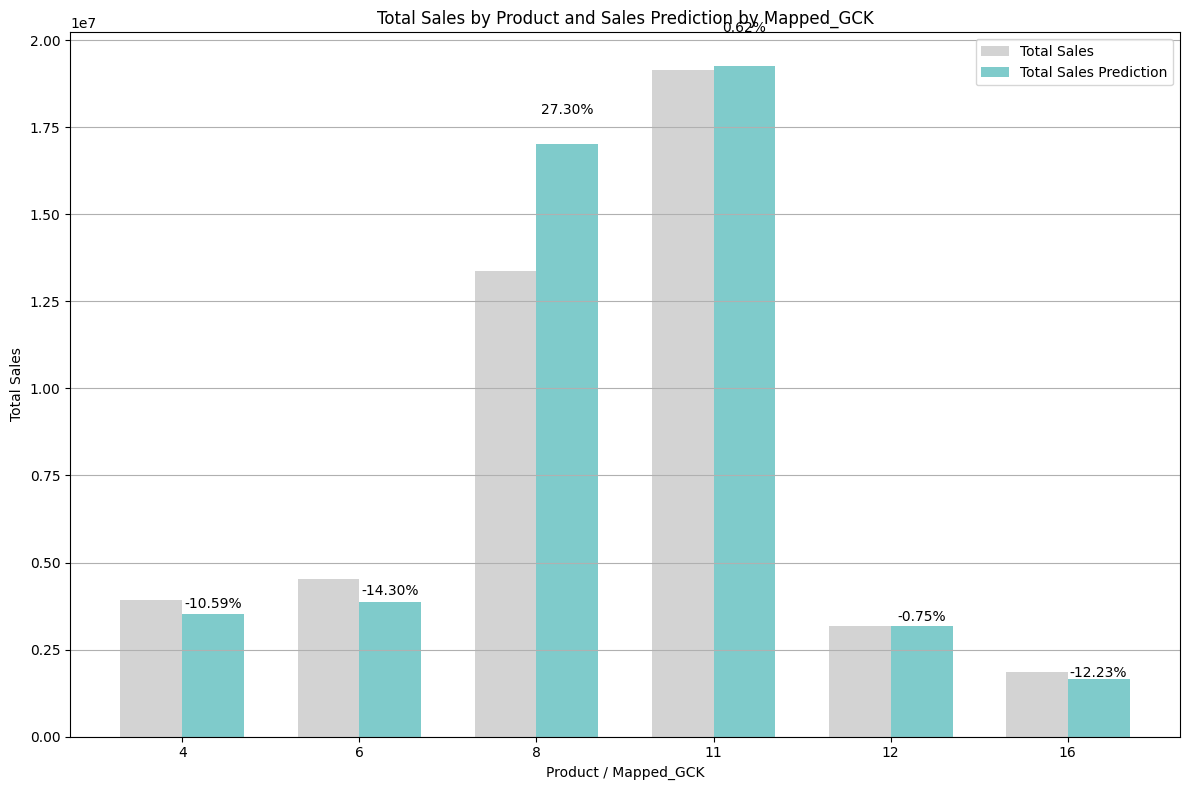

In [273]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming remerged_data is your DataFrame and specific_products is defined

specific_dates = ['2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01', '2022-01-01', '2022-02-01']
specific_dates_datetime = pd.to_datetime(specific_dates)

# Initialize an empty dictionary to store filtered DataFrames
filtered_remerged_data = {}

# Iterate through each key (product) in remerged_data
for key, df in remerged_data.items():
    # Convert the 'Date' column to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    # Filter the DataFrame for the desired dates
    filtered_remerged_data[key] = df[df['Date'].isin(specific_dates_datetime)]

# Calculate the total sales for the filtered remerged_data DataFrame for specific products
summed_filtered_sales_specific = {}
specific_products = [4, 6, 8, 11, 12,  16]
for product_key, df in filtered_remerged_data.items():
    if product_key in specific_products:
        summed_filtered_sales_specific[product_key] = df['Sales_CPI_€'].sum()

# Convert the dictionary of summed filtered sales to a DataFrame
summed_filtered_sales_df_specific = pd.DataFrame.from_dict(summed_filtered_sales_specific, orient='index', columns=['Total Sales'])

# Group by Mapped_GCK and sum the Sales_EUR for specific products
sum_sales_predict_specific = sales_predict.groupby('Mapped_GCK')['Sales_EUR'].sum()

# Reorder the sum_sales_predict to match the order of products in summed_filtered_sales_df
sum_sales_predict_ordered_specific = sum_sales_predict_specific.reindex(summed_filtered_sales_df_specific.index)

# Calculate the difference percentage for specific products
difference_percentage_specific = ((sum_sales_predict_ordered_specific - summed_filtered_sales_df_specific['Total Sales']) / summed_filtered_sales_df_specific['Total Sales']) * 100

## Plotting
plt.figure(figsize=(12, 8))

# Define the width of each bar
bar_width = 0.35

# Define the index for the x-axis for the first bar plot (filtered remerged_data)
index_filtered_specific = range(len(summed_filtered_sales_df_specific))

# Plot the bar plot for total sales by product (filtered remerged_data) for specific products
plt.bar(index_filtered_specific, summed_filtered_sales_df_specific['Total Sales'], bar_width, color='lightgray', label='Total Sales ')

# Define the index for the x-axis for the second bar plot (sales prediction) for specific products
index_predict_specific = [i + bar_width for i in index_filtered_specific]

# Plot the bar plot for total sales prediction by Mapped_GCK for specific products
plt.bar(index_predict_specific, sum_sales_predict_ordered_specific, bar_width, color="#009999", alpha=0.5, label='Total Sales Prediction')

# Display the difference percentage as text on the graph for specific products
for i, (x, y) in enumerate(zip(index_predict_specific, sum_sales_predict_ordered_specific)):
    plt.text(x, y + 0.05 * y, f'{difference_percentage_specific.iloc[i]:.2f}%', ha='center')

# Set the x-axis ticks
plt.xticks([i + bar_width / 2 for i in index_filtered_specific], summed_filtered_sales_df_specific.index)

plt.title('Total Sales by Product and Sales Prediction by Mapped_GCK')
plt.xlabel('Product / Mapped_GCK')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


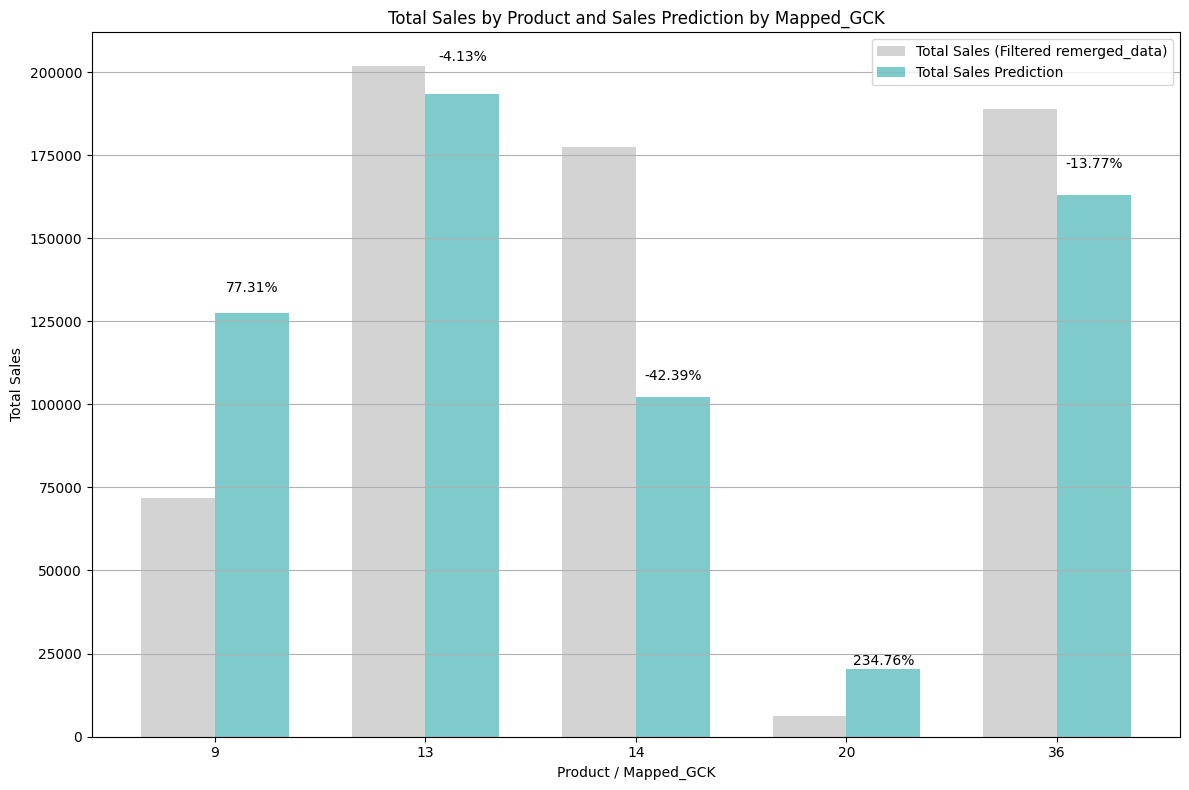

In [272]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming remerged_data is your DataFrame and specific_products is defined

specific_dates = ['2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01', '2022-01-01', '2022-02-01']
specific_dates_datetime = pd.to_datetime(specific_dates)

# Initialize an empty dictionary to store filtered DataFrames
filtered_remerged_data = {}

# Iterate through each key (product) in remerged_data
for key, df in remerged_data.items():
    # Convert the 'Date' column to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    # Filter the DataFrame for the desired dates
    filtered_remerged_data[key] = df[df['Date'].isin(specific_dates_datetime)]

# Calculate the total sales for the filtered remerged_data DataFrame for specific products
summed_filtered_sales_specific = {}
specific_products = [9, 13,14,20,36]
for product_key, df in filtered_remerged_data.items():
    if product_key in specific_products:
        summed_filtered_sales_specific[product_key] = df['Sales_CPI_€'].sum()

# Convert the dictionary of summed filtered sales to a DataFrame
summed_filtered_sales_df_specific = pd.DataFrame.from_dict(summed_filtered_sales_specific, orient='index', columns=['Total Sales'])

# Group by Mapped_GCK and sum the Sales_EUR for specific products
sum_sales_predict_specific = sales_predict.groupby('Mapped_GCK')['Sales_EUR'].sum()

# Reorder the sum_sales_predict to match the order of products in summed_filtered_sales_df
sum_sales_predict_ordered_specific = sum_sales_predict_specific.reindex(summed_filtered_sales_df_specific.index)

# Calculate the difference percentage for specific products
difference_percentage_specific = ((sum_sales_predict_ordered_specific - summed_filtered_sales_df_specific['Total Sales']) / summed_filtered_sales_df_specific['Total Sales']) * 100

## Plotting
plt.figure(figsize=(12, 8))

# Define the width of each bar
bar_width = 0.35

# Define the index for the x-axis for the first bar plot (filtered remerged_data)
index_filtered_specific = range(len(summed_filtered_sales_df_specific))

# Plot the bar plot for total sales by product (filtered remerged_data) for specific products
plt.bar(index_filtered_specific, summed_filtered_sales_df_specific['Total Sales'], bar_width, color='lightgray', label='Total Sales (Filtered remerged_data)')

# Define the index for the x-axis for the second bar plot (sales prediction) for specific products
index_predict_specific = [i + bar_width for i in index_filtered_specific]

# Plot the bar plot for total sales prediction by Mapped_GCK for specific products
plt.bar(index_predict_specific, sum_sales_predict_ordered_specific, bar_width, color="#009999", alpha=0.5, label='Total Sales Prediction')

# Display the difference percentage as text on the graph for specific products
for i, (x, y) in enumerate(zip(index_predict_specific, sum_sales_predict_ordered_specific)):
    plt.text(x, y + 0.05 * y, f'{difference_percentage_specific.iloc[i]:.2f}%', ha='center')

# Set the x-axis ticks
plt.xticks([i + bar_width / 2 for i in index_filtered_specific], summed_filtered_sales_df_specific.index)

plt.title('Total Sales by Product and Sales Prediction by Mapped_GCK')
plt.xlabel('Product / Mapped_GCK')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:
test_set.to_csv('Final Predictions.csv', index=False)